
# Experiment Analysis (setup results)

Two blocks:
1) **Hessian eigenvalue tubes**: mean ± std across steps for sorted eigenvalues, **with index-range selection**.
2) **Many-runs PCA**: fit PCA on the sample-mean trajectory; plot PC pairs for all samples.


In [1]:

import os, json
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#!/usr/bin/env python3
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA
#!/usr/bin/env python3
import torch, numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Hessians stats

In [2]:

# --- CONFIG ---
SETUP_NUM = 2
BASE_DIR = Path('./')
RESULTS_DIR = BASE_DIR / f'setup{SETUP_NUM}'

# Hessian LRs to analyze
LRS_HESS = [0.1, 0.01]

print("Using RESULTS_DIR =", RESULTS_DIR)


Using RESULTS_DIR = setup2


[load] setup2/hessians_traj_lr0.01.pt


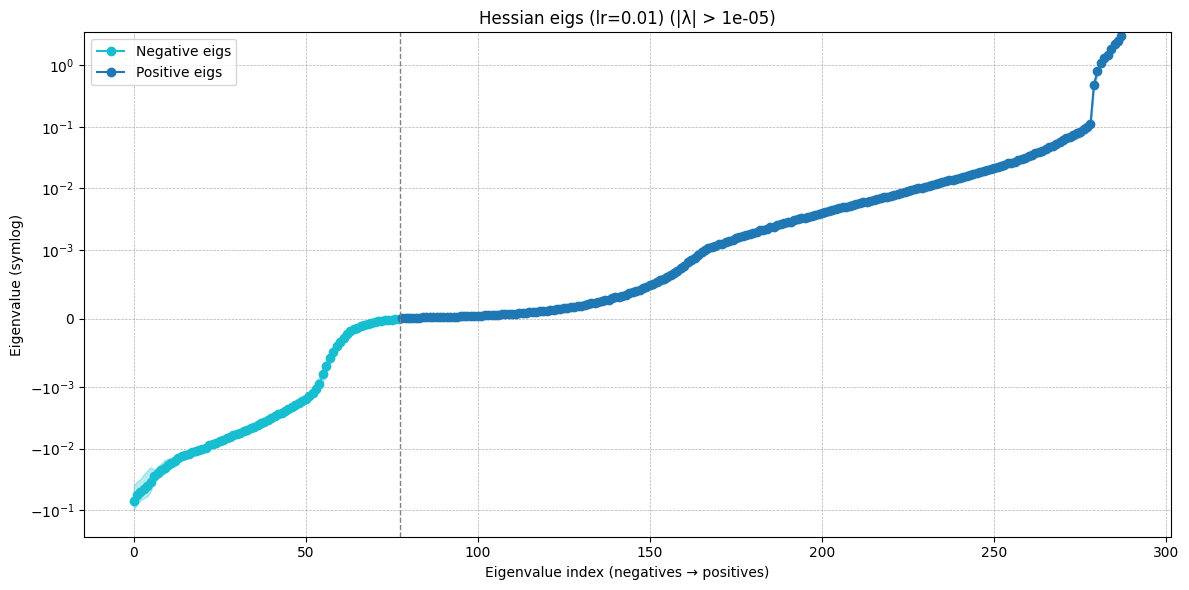

[saved] setup2/significant_eigs_lr0.01.png
[load] setup2/hessians_traj_lr0.1.pt


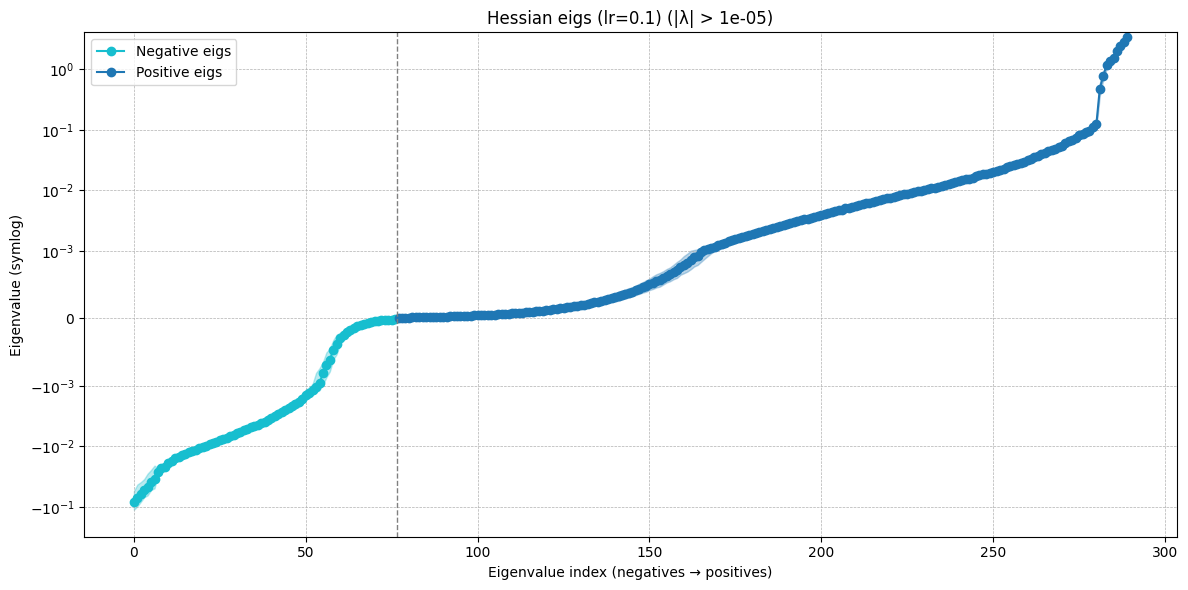

[saved] setup2/significant_eigs_lr0.1.png


In [3]:
#!/usr/bin/env python3
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

epsilon = 1e-5  # порог значимости

def compute_sorted_eigs_for_stack(h_stack: torch.Tensor, max_steps=None) -> np.ndarray:
    """
    h_stack: [steps, n, n]
    return: np.ndarray [steps, n] — eigvals sorted desc
    """
    H = h_stack if max_steps is None else h_stack[:max_steps]
    H = H.detach().cpu().float()
    w = torch.linalg.eigvalsh(H)  # [steps, n], по возрастанию
    return w.flip(-1).numpy()     # [steps, n], по убыванию

def get_filtered_data(mean, std, mask):
    mean_f = mean[mask]
    std_f  = std[mask]
    lower  = np.where(mean_f >= 0, mean_f - std_f, mean_f + std_f)
    upper  = np.where(mean_f >= 0, mean_f + std_f, mean_f - std_f)
    return mean_f, lower, upper

def plot_significant_eigs(eigs_sorted: np.ndarray, title: str, out_path: Path):
    mean_vals = eigs_sorted.mean(0)  # [n]
    std_vals  = eigs_sorted.std(0)

    # маски значимых
    mask_pos = mean_vals >  epsilon
    mask_neg = mean_vals < -epsilon

    def get_filtered_data(mean, std, mask, reverse=False):
        m = mean[mask]
        s = std[mask]
        # порядок: по возрастанию значений
        order = np.argsort(m)
        if reverse:  # для отрицательных можно разворачивать, чтобы шли -∞ ... → 0
            order = order[::-1]
        m, s = m[order], s[order]
        lower = np.where(m >= 0, m - s, m + s)
        upper = np.where(m >= 0, m + s, m - s)
        return m, lower, upper

    # сортируем отрицательные по возрастанию (от более отрицательных к ближним к 0)
    mean_neg, lower_neg, upper_neg = get_filtered_data(mean_vals, std_vals, mask_neg, reverse=False)
    # сортируем положительные по возрастанию (от ближних к 0 до больших)
    mean_pos, lower_pos, upper_pos = get_filtered_data(mean_vals, std_vals, mask_pos, reverse=False)

    # индексы: сначала все отрицательные, потом положительные
    x_neg = np.arange(len(mean_neg))
    x_pos = np.arange(len(mean_pos)) + len(mean_neg)

    fig, ax = plt.subplots(figsize=(12, 6))

    ax.plot(x_neg, mean_neg, 'o-', label='Negative eigs', color='tab:cyan')
    ax.fill_between(x_neg, lower_neg, upper_neg, color='tab:cyan', alpha=0.3)

    ax.plot(x_pos, mean_pos, 'o-', label='Positive eigs', color='tab:blue')
    ax.fill_between(x_pos, lower_pos, upper_pos, color='tab:blue', alpha=0.3)

    ax.axvline(len(mean_neg) - 0.5, color='gray', linestyle='--', linewidth=1)

    ax.set_yscale('symlog', linthresh=1e-3)
    ax.set_title(title + f" (|λ| > {epsilon})")
    ax.set_xlabel("Eigenvalue index (negatives → positives)")
    ax.set_ylabel("Eigenvalue (symlog)")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.savefig(out_path, bbox_inches="tight")
    plt.show()
    plt.close(fig)
    print(f"[saved] {out_path}")


def run_all(results_dir: str | Path, lrs: list[float], max_steps=None):
    results_dir = Path(results_dir)
    for lr in lrs:
        path = results_dir / f"hessians_traj_lr{lr}.pt"
        if not path.exists():
            print(f"[skip] {path}")
            continue
        print(f"[load] {path}")
        h_stack = torch.load(path, map_location="cpu")  # [steps, n, n]
        eigs_sorted = compute_sorted_eigs_for_stack(h_stack, max_steps=max_steps)
        out_png = results_dir / f"significant_eigs_lr{lr}.png"
        plot_significant_eigs(eigs_sorted, f"Hessian eigs (lr={lr})", out_png)

# ==== запуск ====
if __name__ == "__main__":
    run_all(RESULTS_DIR, lrs=[0.01, 0.1], max_steps=None)


## Sampling trajectories

Loaded: setup2/weights_lr0.01.pt | shape: torch.Size([10, 11, 386])


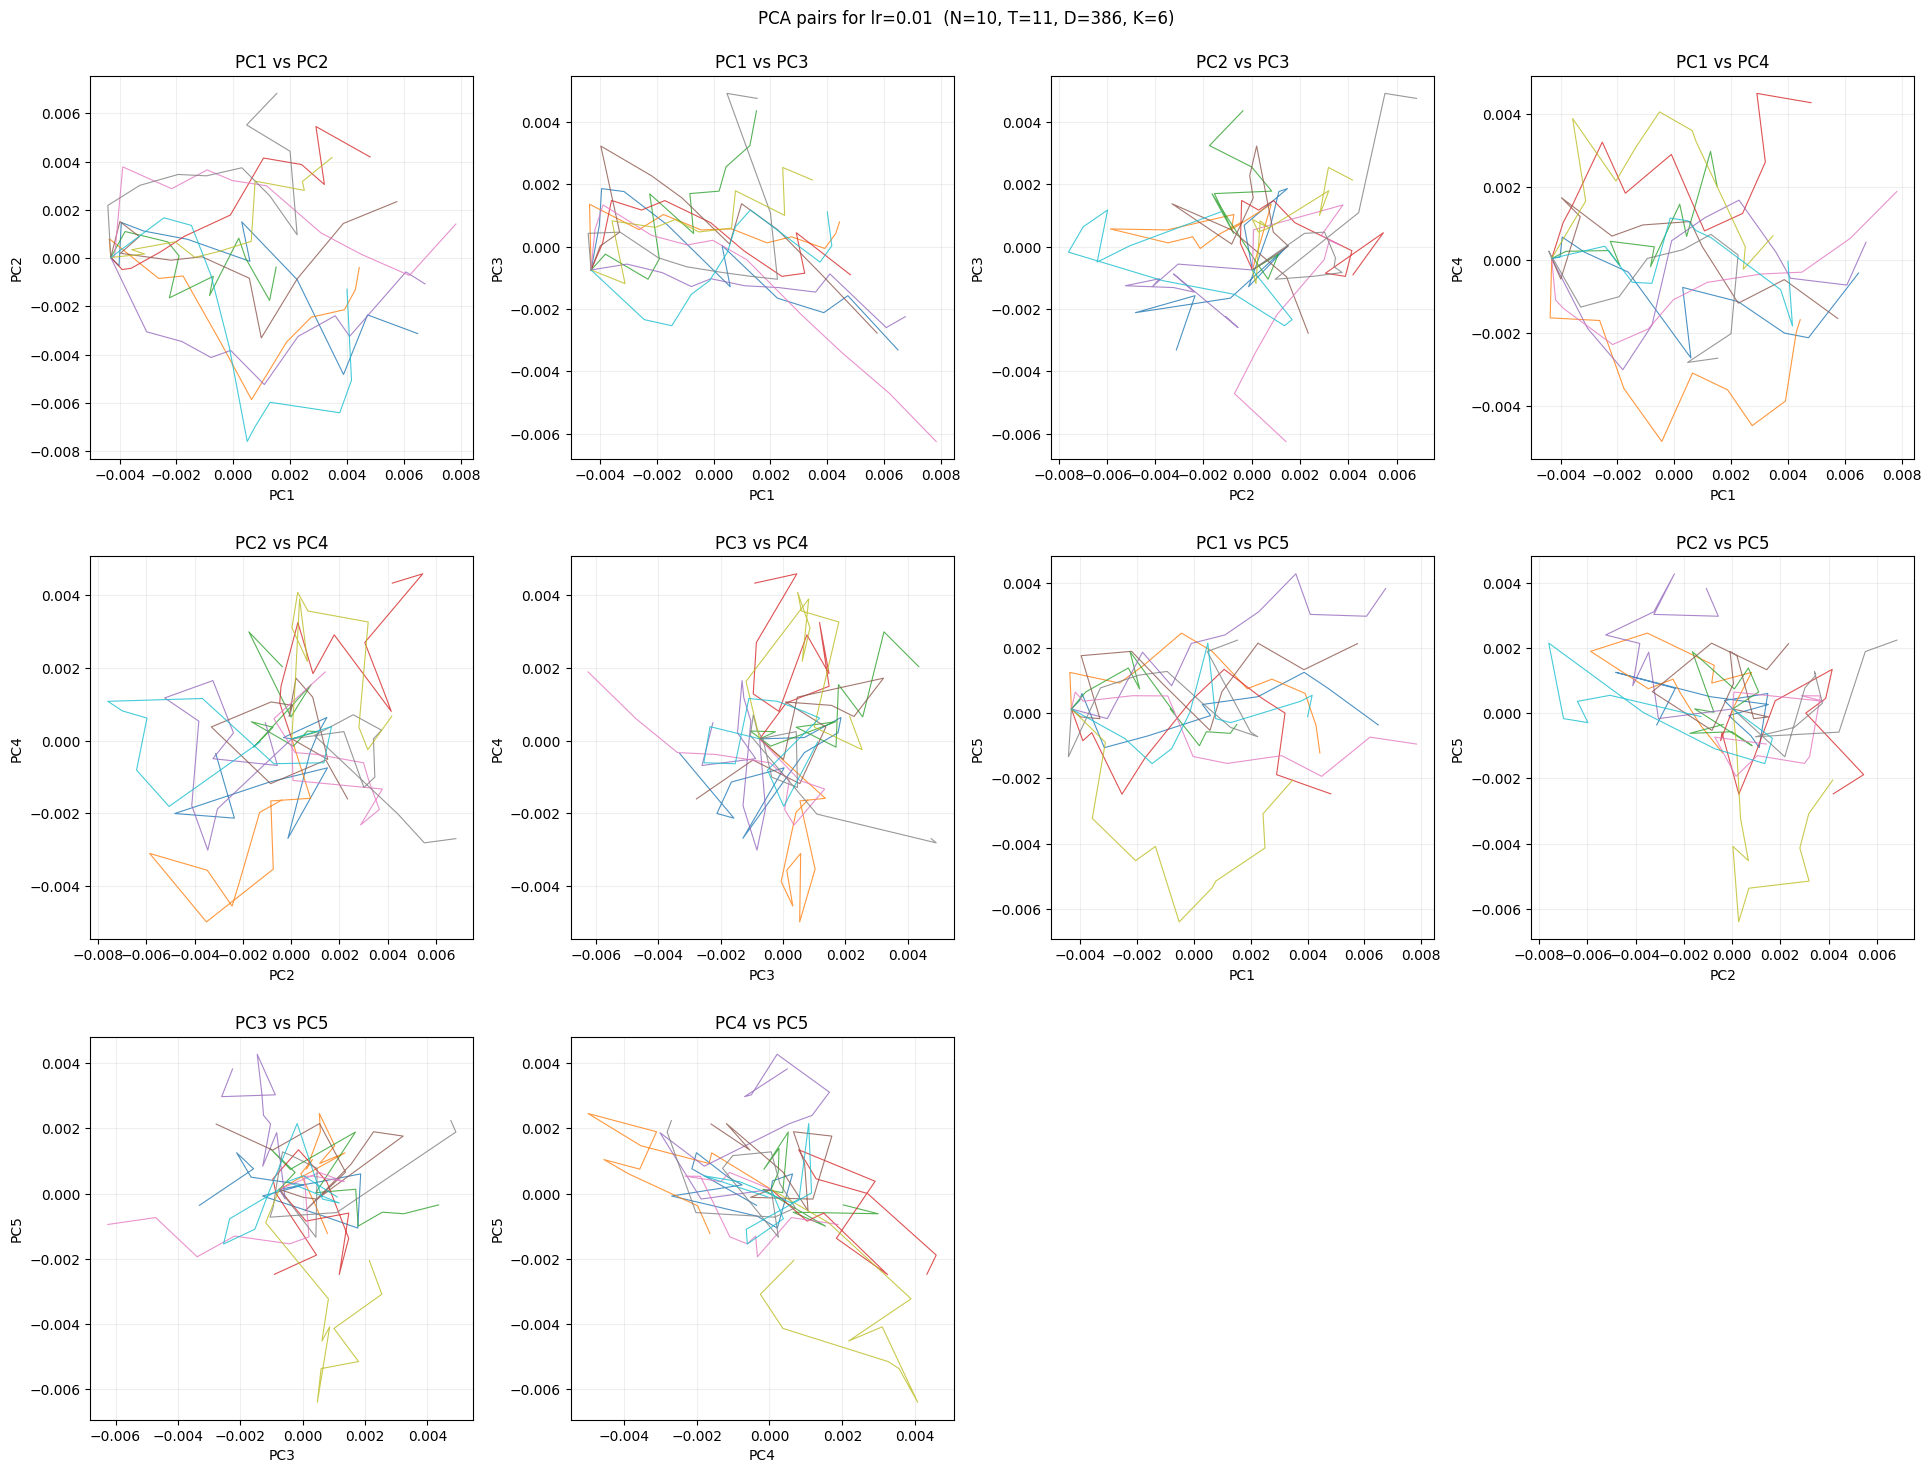

In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os, math
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ----------------- настройки -----------------
BASE_DIR = RESULTS_DIR
PATHS = {
    "0.01": os.path.join(BASE_DIR, "weights_lr0.01.pt"),
    "0.1":  os.path.join(BASE_DIR, "weights_lr0.1.pt"),
}
SELECT_LR = "0.01"   # ← выбери: "0.01" или "0.1"

PAIRS = [(i, j) for j in range(5) for i in range(5) if i < j]  # пары компонент для рисования
N_COMPONENTS = 6         # должно быть > max индекса в PAIRS
N_SHOW = 1000            # сколько траекторий показывать
STEP_STRIDE = 1          # прореживание точек по времени
ALPHA = 0.8
LW = 0.8
SAVE_PNG = None          # например: "pca_pairs_lr0.1.png" или None чтобы показать на экране

# ----------------- утилита отрисовки -----------------
def plot_pairs_compact(Z, pairs, n_show=300, step_stride=5, alpha=0.08, lw=0.8):
    n_show = min(n_show, Z.shape[0])
    idx_traj = np.linspace(0, Z.shape[0]-1, n_show, dtype=int)

    n = len(pairs)
    cols = math.ceil(math.sqrt(n))
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4.8*cols, 4.8*rows),
                             constrained_layout=True, squeeze=False)
    axes = axes.ravel()

    for k, (a, b) in enumerate(pairs):
        ax = axes[k]
        for i in idx_traj:
            xy = Z[i, ::step_stride, :][:, [a, b]]
            ax.plot(xy[:, 0], xy[:, 1], lw=lw, alpha=alpha)
        ax.set_title(f"PC{a+1} vs PC{b+1}", pad=6)
        ax.set_xlabel(f"PC{a+1}")
        ax.set_ylabel(f"PC{b+1}")
        ax.relim(); ax.autoscale()
        try:
            ax.set_box_aspect(1)
        except Exception:
            ax.set_aspect('equal', adjustable='datalim')
        ax.grid(True, alpha=0.2)

    for j in range(k+1, rows*cols):
        fig.delaxes(axes[j])

    return fig

# ----------------- загрузка -----------------
PATH = PATHS[SELECT_LR]
W = torch.load(PATH, map_location="cpu").detach().float()   # ожидаем [N, T, D]
if not isinstance(W, torch.Tensor) or W.ndim != 3:
    raise ValueError(f"Ожидался тензор формы [N, T, D], получено: {type(W)} с ndim={getattr(W, 'ndim', None)}")
N, T, D = W.shape
print(f"Loaded: {PATH} | shape: {W.shape}")

# ----------------- PCA по усреднённой траектории -----------------
# усредняем по траекториям -> [T, D]
mean_traj = W.mean(dim=0)                                  # [T, D] torch
X = (mean_traj - mean_traj.mean(dim=0, keepdim=True)).numpy()  # numpy
pca = PCA(n_components=N_COMPONENTS).fit(X)
K = pca.n_components_
center = mean_traj.mean(dim=0, keepdim=True).numpy().astype(np.float32)  # [1, D]
P_T = pca.components_.T.astype(np.float32)                                 # [D, K]

# ----------------- проекция всех траекторий -----------------
W_np = W.numpy().astype(np.float32, copy=False)            # [N, T, D]
Z = np.einsum('ntd,dk->ntk', W_np - center, P_T, optimize=True)  # [N, T, K]

# ----------------- рисуем -----------------
fig = plot_pairs_compact(Z, PAIRS, n_show=N_SHOW, step_stride=STEP_STRIDE, alpha=ALPHA, lw=LW)
fig.suptitle(f"PCA pairs for lr={SELECT_LR}  (N={N}, T={T}, D={D}, K={K})", y=1.02, fontsize=12)

if SAVE_PNG:
    plt.savefig(SAVE_PNG, dpi=150, bbox_inches="tight")
else:
    plt.show()


## Отдельный параметр отслеживаем 


[loaded] setup2/weights_lr0.1.pt | shape = (N=10, T=11, D=386)


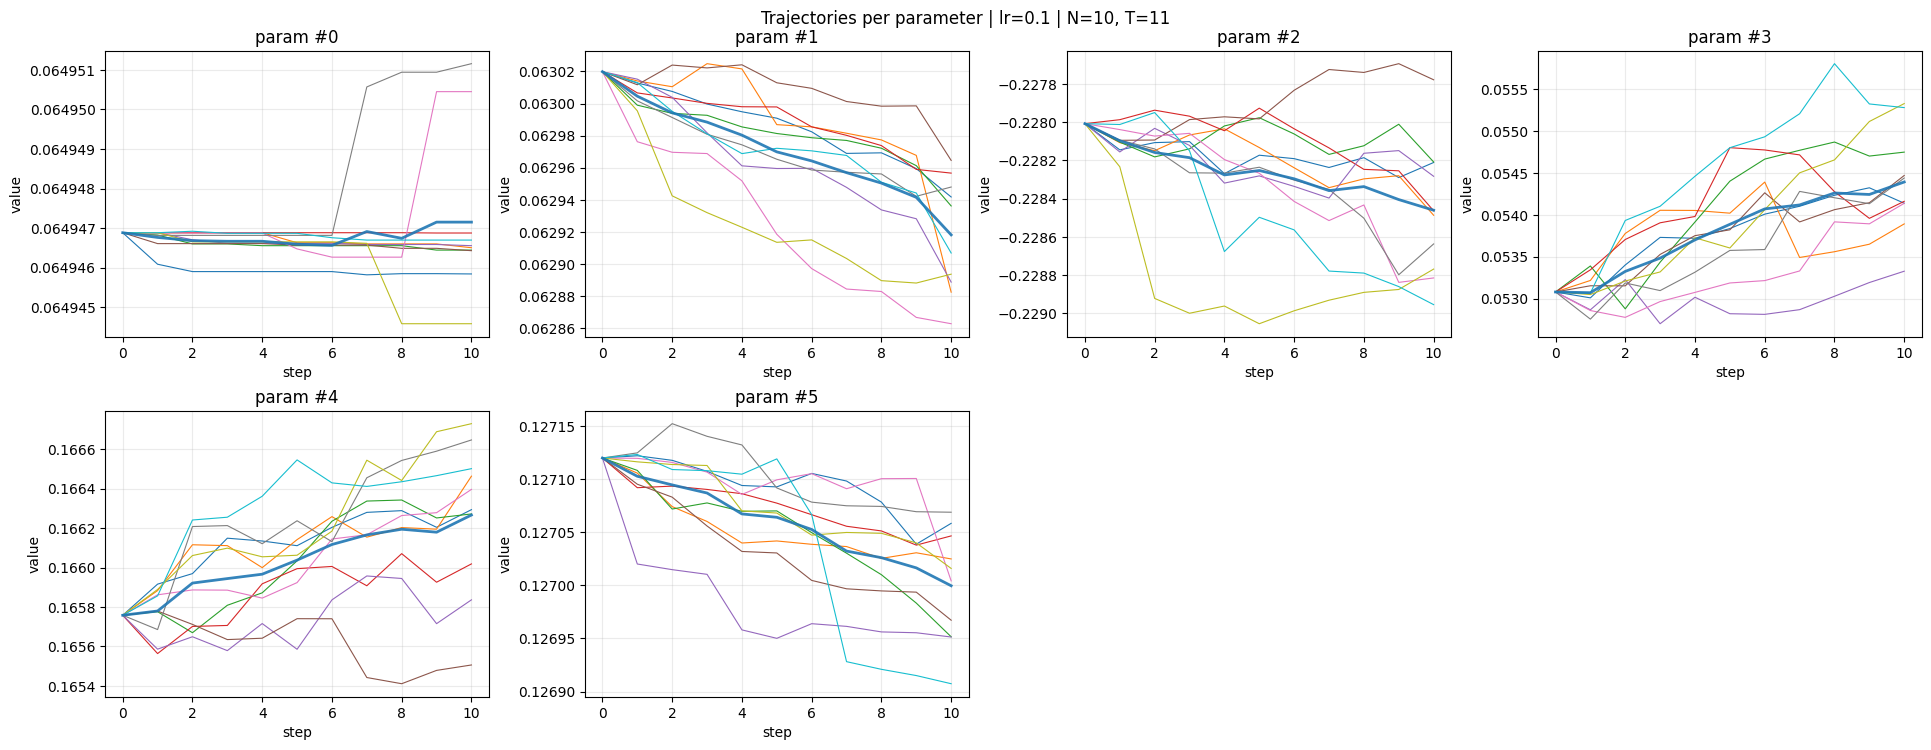

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os, math
import numpy as np
import torch
import matplotlib.pyplot as plt

# ============== настройки ==============
BASE_DIR = RESULTS_DIR
LR_TO_USE = "0.1"  # "0.01" или "0.1"
PATH = os.path.join(BASE_DIR, f"weights_lr{LR_TO_USE}.pt")  # ожидаем shape [N, T, D]

# Список параметров (индексы по плоскому вектору весов модели) для отрисовки
PARAM_IDS = [0, 1, 2, 3, 4, 5]     # <-- поменяй под себя

# Отрисовочные параметры
N_SHOW       = 1000      # сколько траекторий максимум рисовать (<= N)
STEP_STRIDE  = 1         # прореживание времени, каждые STEP_STRIDE шагов
ALPHA        = 1.0      # прозрачность линий траекторий
LW           = 0.8       # толщина линии
SHOW_MEAN    = True      # рисовать поверх среднюю траекторию
MEAN_LW      = 2.0
UNIFY_YLIMS  = False     # одинаковые y-границы на всех сабплотах
SAVE_PNG     = None      # например: f"params_grid_lr{LR_TO_USE}.png" или None, чтобы показать на экране

# ============== загрузка ==============
W = torch.load(PATH, map_location="cpu")
if not isinstance(W, torch.Tensor) or W.ndim != 3:
    raise ValueError(f"Ожидался тензор [N, T, D], получено: {type(W)} c ndim={getattr(W, 'ndim', None)}")
W = W.detach().float()
N, T, D = W.shape
print(f"[loaded] {PATH} | shape = (N={N}, T={T}, D={D})")

# sanity-check для индексов параметров
if len(PARAM_IDS) == 0:
    raise ValueError("PARAM_IDS пуст — задай индексы параметров для отрисовки.")
bad = [p for p in PARAM_IDS if not (0 <= p < D)]
if bad:
    raise IndexError(f"Некорректные индексы параметров (за пределами [0, {D-1}]): {bad}")

# ============== подготовка данных ==============
# приводим к numpy (без копии если возможно)
Wnp = W.numpy().astype(np.float32, copy=False)  # [N, T, D]
n_show = min(N_SHOW, N)
traj_idx = np.linspace(0, N-1, n_show, dtype=int)  # равномерный выбор без случайности

t_idx = np.arange(0, T, STEP_STRIDE, dtype=int)    # прореживание времени
t_axis = t_idx                                      # для подписи X (индексы шагов)

# заранее посчитаем среднюю траекторию по N (если нужно)
mean_traj = Wnp.mean(axis=0, dtype=np.float64)      # [T, D], double для точности

# глобальные границы по Y (если нужно одинаковые лимиты)
global_ymin, global_ymax = None, None
if UNIFY_YLIMS:
    vals = []
    for p in PARAM_IDS:
        vals.append(Wnp[traj_idx][:, t_idx, p])     # [n_show, T'] фрагменты по параметру
    vals = np.concatenate([v.reshape(-1) for v in vals], axis=0)
    global_ymin, global_ymax = float(np.min(vals)), float(np.max(vals))
    # небольшой паддинг
    dy = (global_ymax - global_ymin) * 0.05 if global_ymax > global_ymin else 1.0
    global_ymin -= dy; global_ymax += dy

# ============== рисуем сетку сабплотов ==============
n = len(PARAM_IDS)
cols = min(4, n)                      # до 4 столбцов, дальше растём в строки
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4.8*cols, 3.6*rows), squeeze=False, constrained_layout=True)
axes = axes.ravel()

for ax, p in zip(axes, PARAM_IDS):
    # все траектории выбранного параметра (прореженные по времени)
    Y = Wnp[traj_idx][:, t_idx, p]    # [n_show, T']
    for k in range(Y.shape[0]):
        ax.plot(t_axis, Y[k], alpha=ALPHA, lw=LW)

    if SHOW_MEAN:
        m = mean_traj[t_idx, p].astype(np.float32, copy=False)
        ax.plot(t_axis, m, lw=MEAN_LW, alpha=0.9)

    ax.set_title(f"param #{p}", pad=6)
    ax.set_xlabel("step")
    ax.set_ylabel("value")
    ax.grid(True, alpha=0.25)

    if UNIFY_YLIMS and global_ymin is not None:
        ax.set_ylim(global_ymin, global_ymax)
    else:
        ax.relim(); ax.autoscale()

# скрыть пустые оси, если PARAM_IDS < rows*cols
for j in range(len(PARAM_IDS), rows*cols):
    fig.delaxes(axes[j])

fig.suptitle(f"Trajectories per parameter | lr={LR_TO_USE} | N={N}, T={T}", y=1.02, fontsize=12)

if SAVE_PNG:
    plt.savefig(SAVE_PNG, dpi=150, bbox_inches="tight")
else:
    plt.show()
